# Penalties Data Exploratory Data Analysis

This notebook provides an exploratory analysis of penalty data from NFL games, detailing penalty types, frequency, and characteristics across different teams and games.

## Import Libraries

In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data

In [2]:
# Load the penalties data from CSV file
df = pd.read_csv('../data/processed/penalties.csv')

df.head()

,game_id,team_id,opp_id,penalty,player,pos,date,year,week,quarter,...,time_left,down,dist,ref_crew,declined,offsetting,yardage,home,postseason,phase
0,2009_1_TEN_PIT,PIT,TEN,Def_Unnecessary_Roughness,T.Polamalu,SS,2009-09-10,2009,1,1,...,00:53:20,1,10,Bill Leavy,No,No,15,Yes,No,Def
1,2009_1_TEN_PIT,TEN,PIT,Off_Illegal_Formation,D.Stewart,T,2009-09-10,2009,1,1,...,00:49:27,1,10,Bill Leavy,No,No,5,No,No,Off
2,2009_1_TEN_PIT,PIT,TEN,Off_Holding,H.Ward,WR,2009-09-10,2009,1,2,...,00:40:19,2,1,Bill Leavy,No,No,10,Yes,No,Off
3,2009_1_TEN_PIT,PIT,TEN,Off_Holding,M.Starks,T,2009-09-10,2009,1,2,...,00:39:54,2,6,Bill Leavy,No,No,10,Yes,No,Off
4,2009_1_TEN_PIT,PIT,TEN,Def_Pass_Interference,T.Polamalu,SS,2009-09-10,2009,1,2,...,00:35:19,2,7,Bill Leavy,No,Yes,0,Yes,No,Def


## Data Filtering

Filter penalties to only include those that occur 50+ times and exclude special teams penalties.

In [3]:
# Count the frequency of each penalty type
penalties_count = df['penalty'].value_counts()

# Filter for penalties that occur at least 50 times
frequent_penalties = penalties_count[penalties_count >= 50].index.tolist()

# Exclude special teams penalties and filter by frequent penalties
filtered_penalties = df[(df['phase'] != 'ST') & (df['penalty'].isin(frequent_penalties))]

# Split the data into offense and defense phases
off_penalties = filtered_penalties[filtered_penalties['phase'] == 'Off']
def_penalties = filtered_penalties[filtered_penalties['phase'] == 'Def']

## Most Common Penalties

Analyze the most common penalties for both offense and defense.

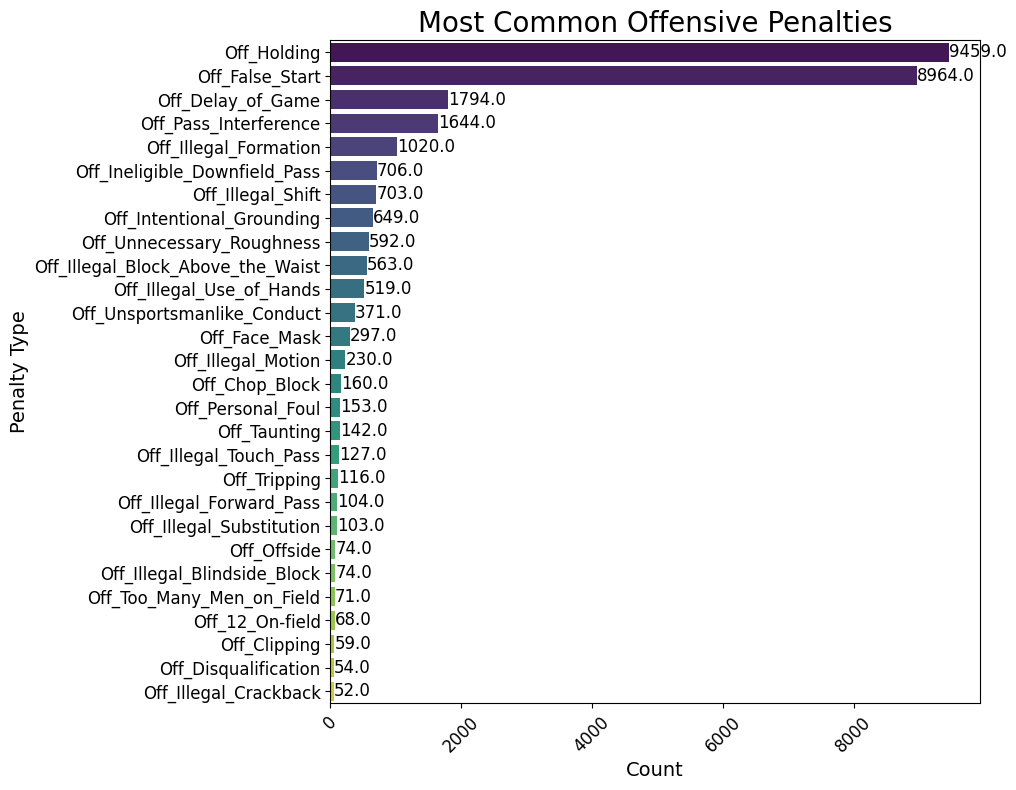

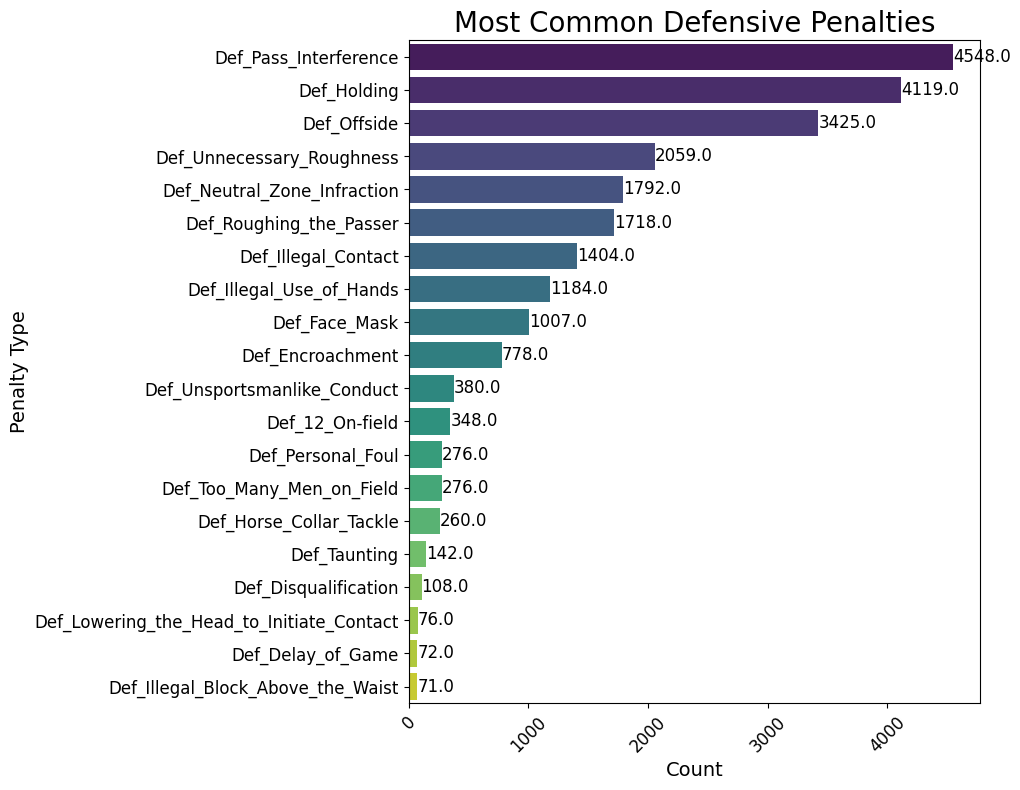

In [4]:
# Function to create horizontal bar plots with adjusted styling
def create_styled_barh(data, x, y, title, xlabel, ylabel, figsize=(10, 8)):
    # Set the palette to viridis based on the number of unique y-values
    unique_y = data[y].nunique()
    palette = sns.color_palette("viridis", unique_y)
    
    # Create the bar plot
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=x, y=y, data=data, palette=palette, dodge=False)
    
    # Customize the plot to make it more readable
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    # Add value labels to each bar for better readability
    for p in ax.patches:
        width = p.get_width()
        ax.text(width, p.get_y() + p.get_height() / 2,
                f'{width:.1f}',
                va='center', fontsize=12)
    
    # Show the plot
    plt.show()


# Most common offensive penalties
off_common_penalties = off_penalties['penalty'].value_counts().reset_index()
off_common_penalties.columns = ['penalty', 'count']
create_styled_barh(off_common_penalties, 'count', 'penalty', 'Most Common Offensive Penalties', 'Count', 'Penalty Type')

# Most common defensive penalties
def_common_penalties = def_penalties['penalty'].value_counts().reset_index()
def_common_penalties.columns = ['penalty', 'count']
create_styled_barh(def_common_penalties, 'count', 'penalty', 'Most Common Defensive Penalties', 'Count', 'Penalty Type')

## Most Yards Given Up by Penalty

This section investigates which penalties have resulted in the most yards lost, separately for offensive and defensive penalties.

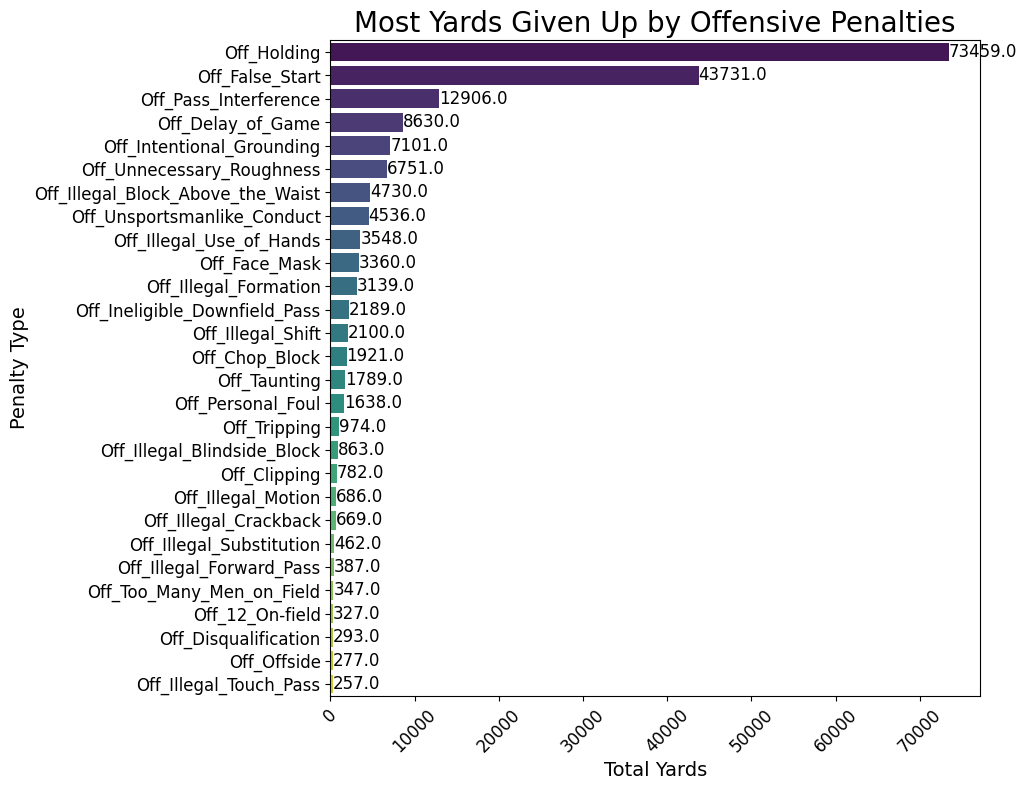

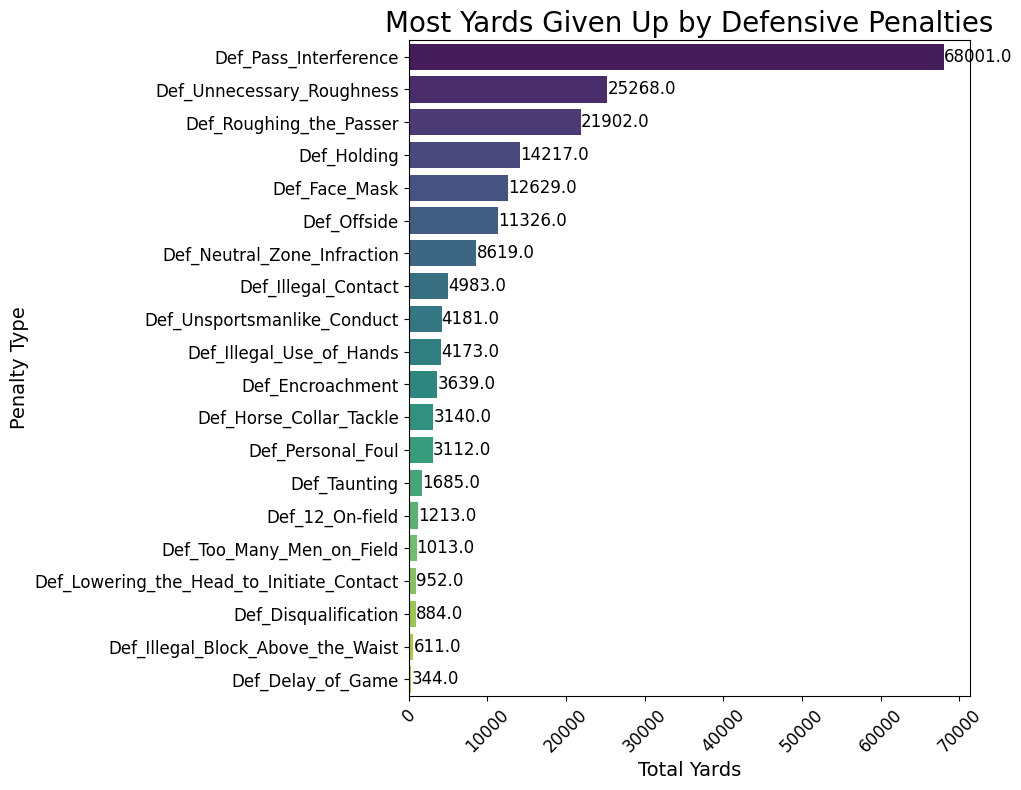

In [5]:
# Calculate the total yards given up by penalty for offense
off_yards_by_penalty = off_penalties.groupby('penalty')['yardage'].sum().sort_values(ascending=False).reset_index()
off_yards_by_penalty.columns = ['penalty', 'total_yards']

# Calculate the total yards given up by penalty for defense
def_yards_by_penalty = def_penalties.groupby('penalty')['yardage'].sum().sort_values(ascending=False).reset_index()
def_yards_by_penalty.columns = ['penalty', 'total_yards']

# Plot for most yards given up by offensive penalties
create_styled_barh(off_yards_by_penalty, 'total_yards', 'penalty', 'Most Yards Given Up by Offensive Penalties', 'Total Yards', 'Penalty Type')

# Plot for most yards given up by defensive penalties
create_styled_barh(def_yards_by_penalty, 'total_yards', 'penalty', 'Most Yards Given Up by Defensive Penalties', 'Total Yards', 'Penalty Type')

## Most Yards Given Up by Team

This section examines which teams have given up the most yards due to penalties.

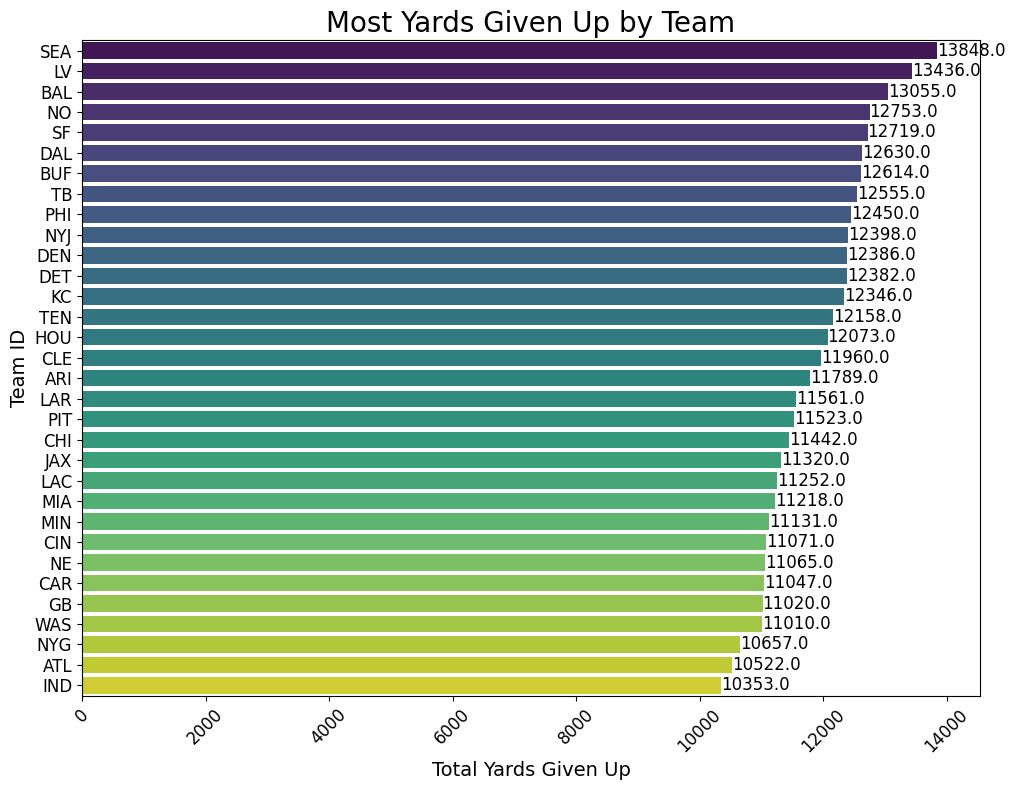

In [6]:
# Combine offense and defense data frames for team analysis
combined_penalties = pd.concat([off_penalties, def_penalties])

# Calculate the total yards given up by team
yards_given_up_by_team = combined_penalties.groupby('team_id')['yardage'].sum().sort_values(ascending=False).reset_index()
yards_given_up_by_team.columns = ['team_id', 'total_yards_given_up']

# Plot for most yards given up by team
create_styled_barh(yards_given_up_by_team, 'total_yards_given_up', 'team_id', 'Most Yards Given Up by Team', 'Total Yards Given Up', 'Team ID')

## Most Yards Gained by Team

Next, we explore which teams have gained the most yards from penalties called on the opposing team.

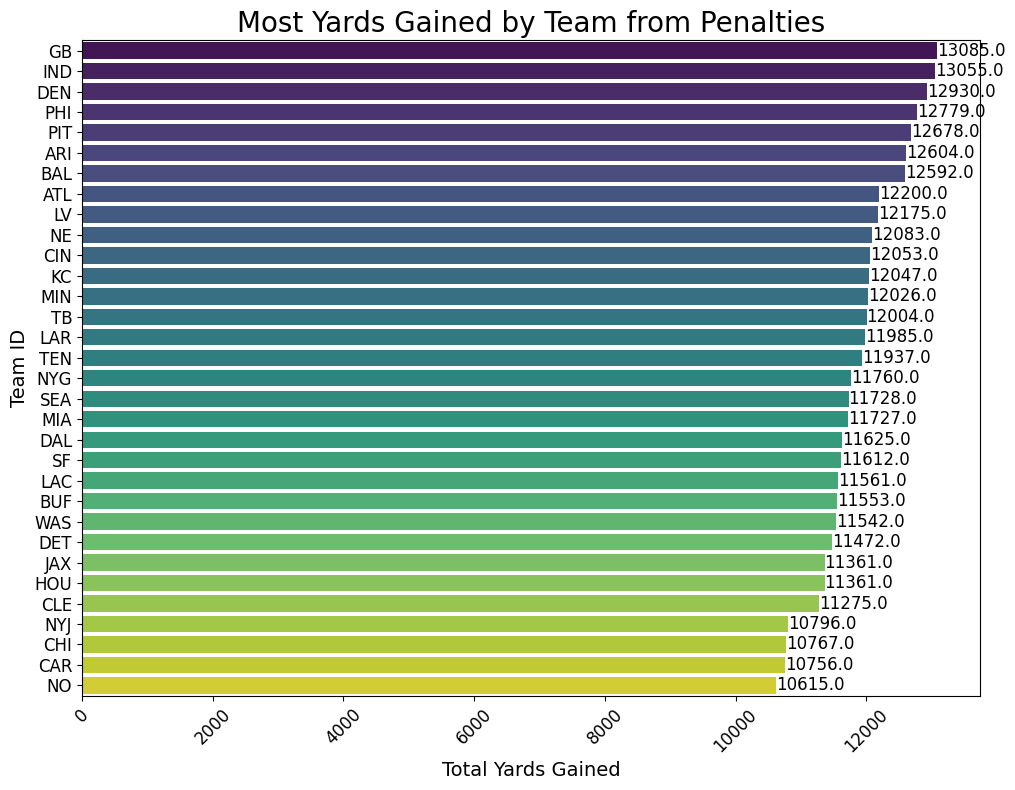

In [7]:
# Calculate the total yards gained by team (using opponent ID to identify the team gaining yards)
yards_gained_by_team = combined_penalties.groupby('opp_id')['yardage'].sum().sort_values(ascending=False).reset_index()
yards_gained_by_team.columns = ['team_id', 'total_yards_gained']

# Plot for most yards gained by team
create_styled_barh(yards_gained_by_team, 'total_yards_gained', 'team_id', 'Most Yards Gained by Team from Penalties', 'Total Yards Gained', 'Team ID')

## Penalties by Position

This section investigates the distribution of penalties across different player positions on the field.

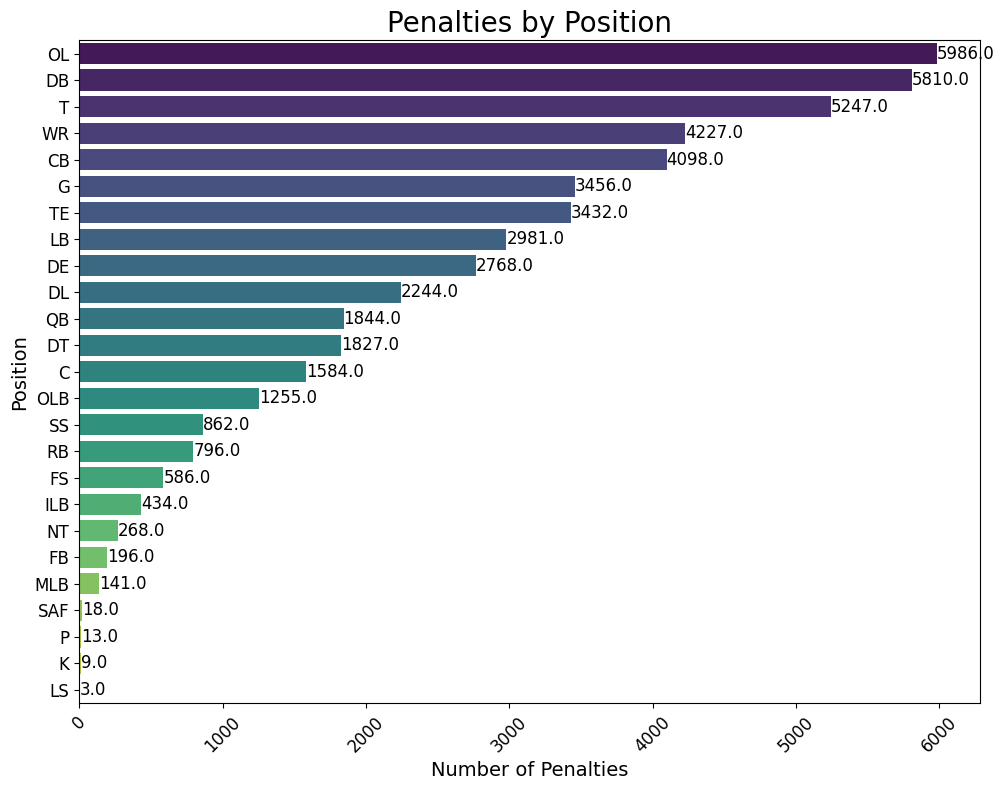

In [8]:
# Group the data by position and count the number of penalties for each
penalties_by_position = combined_penalties.groupby('pos')['penalty'].count().sort_values(ascending=False).reset_index()
penalties_by_position.columns = ['Position', 'Penalty Count']

# Plot for penalties by position
create_styled_barh(penalties_by_position, 'Penalty Count', 'Position', 'Penalties by Position', 'Number of Penalties', 'Position')

## Penalties by Referee Crew

This section provides an in-depth look at the behavior of different referee crews in terms of the penalties they call during games. We'll start by analyzing the number of penalties per game for each referee crew and then dive into the types of penalties they most frequently call.

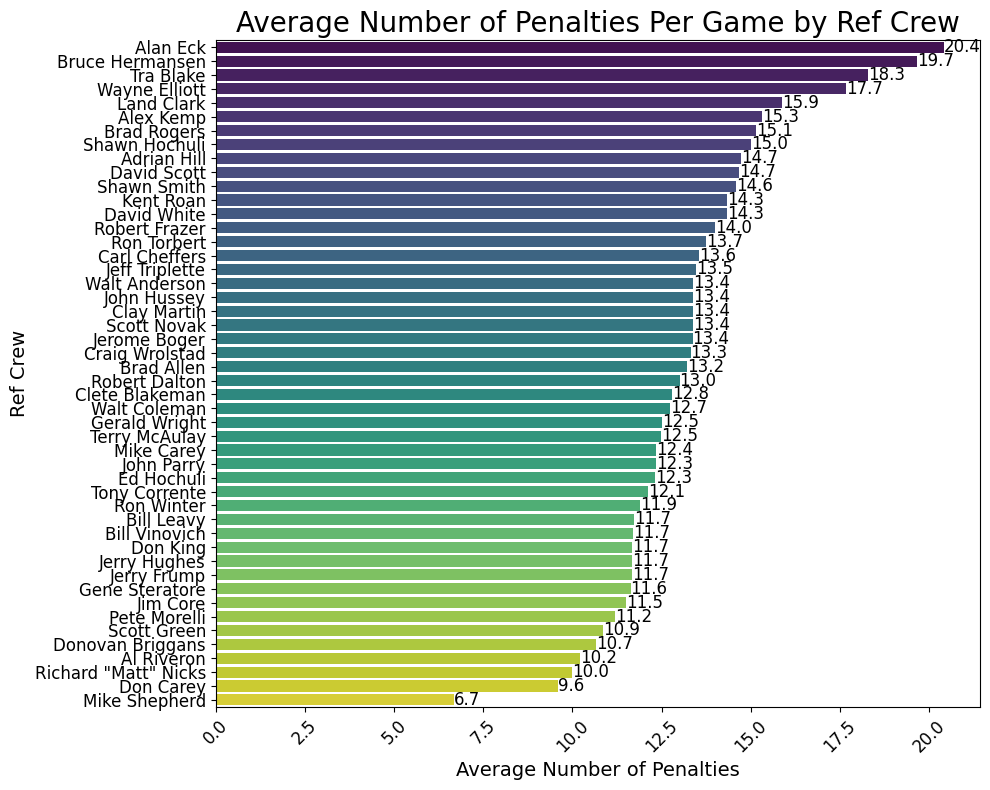

In [9]:
# Calculate the number of penalties per game for each ref crew
penalties_per_game_by_crew = combined_penalties.groupby(['ref_crew', 'game_id']).size().groupby(level=0).mean().sort_values(ascending=False).reset_index()
penalties_per_game_by_crew.columns = ['Ref Crew', 'Avg Penalties Per Game']

# Plot for number of penalties per game per ref crew
create_styled_barh(penalties_per_game_by_crew, 'Avg Penalties Per Game', 'Ref Crew', 'Average Number of Penalties Per Game by Ref Crew', 'Average Number of Penalties', 'Ref Crew')

## Time Series Analysis

C:\Users\Eric\AppData\Local\Temp\ipykernel_28604\3599508125.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['minutes_into_game'] = 60 - filtered_df['total_minutes_left']


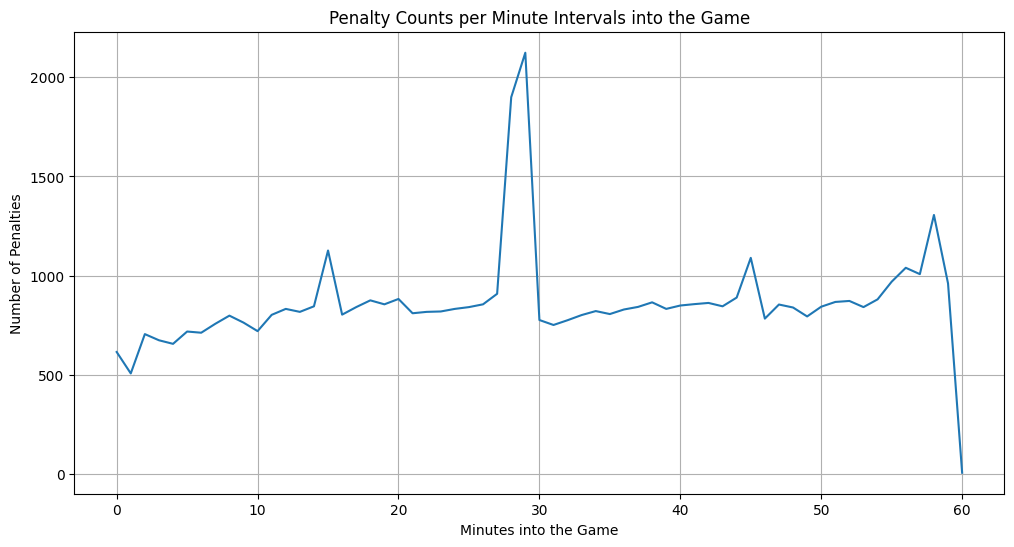

In [12]:
# Convert 'time_left' to total minutes left in the game
combined_penalties['time_left'] = pd.to_timedelta(combined_penalties['time_left'])
combined_penalties['total_minutes_left'] = combined_penalties['time_left'].dt.total_seconds() / 60

# Remove entries with negative time left values
filtered_df = combined_penalties[combined_penalties['total_minutes_left'] >= 0]

# Convert 'total_minutes_left' to 'minutes_into_game'
filtered_df['minutes_into_game'] = 60 - filtered_df['total_minutes_left']

# Group by 'minutes_into_game' and count the number of penalties per minute
time_series_data = filtered_df.groupby(filtered_df['minutes_into_game'].astype(int)).size()

# Plot the time series graph with the flipped x-axis
plt.figure(figsize=(12, 6))
time_series_data.plot(kind='line')
plt.title('Penalty Counts per Minute Intervals into the Game')
plt.xlabel('Minutes into the Game')
plt.ylabel('Number of Penalties')
plt.grid(True)
plt.show()